## Training a 4-Output ANN from scratch

In [12]:
######## User Settings ########

#### 1. Select parameters to be used ####
input_var = ['SAC','Exp','SJR','DICU','Vern','SF_Tide','DXC']
#### 2. Select stations to be predicted ####
# choose within 'Emmaton','Jersey Point','Collinsville','Rock Slough'
output_stations=['Emmaton','Jersey Point','Collinsville','Rock Slough']
#### 3. Specify directory to excel dataset and the helper script (folder name only) ####
google_drive_dir = 'python_ANN'

###### User Settings Finished ######


from google.colab import drive
import os
data_in_google_drive = True

# Mount Google drive
if data_in_google_drive:
    drive.mount('/content/drive')
    xl_path = os.path.join('/content/drive','My Drive',google_drive_dir,"ANN_data.xlsx")
    %tensorflow_version 1.x
else:
    xl_path = "ANN_data.xlsx"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. Read data

In [0]:
import sys
sys.path.append(os.path.join('/content/drive','My Drive',google_drive_dir))
from ann_helper import normalize_in,read_data,writeF90,initnw,show_eval

In [14]:
import tensorflow as tf
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
# from sklearn.utils import shuffle

test_mode = False

locs = {'Emmaton':0,'Jersey Point':1,'Collinsville':2,'Rock Slough':3}
abbrev_map = {'rock slough':'ORRSL','rockslough':'ORRSL',
            'emmaton':'EMM','jersey point':'JP','jerseypoint':'JP',
            'antioch':'antioch','collinsville':'CO',
            'mallard':'Mallard','mallard island':'Mallard',
            'los vaqueros':'LosVaqueros','losvaqueros':'LosVaqueros',
            'martinez':'MTZ',
            'middle river':'MidR_intake','MiddleRiver':'MidR_intake',
            'victoria cannal':'Victoria_intake','Vict Intake':'Victoria_intake',
            'cvp intake':'CVP_intake','clfct forebay':'CCFB',
            'clfct forebay intake':'CCFB_intake','x2':'X2'};

output_stations = sorted(output_stations,key=lambda x: locs[x])

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
#   print('xxxxxxxxxxxxxx Using CPU xxxxxxxxxxxxxx')
else:
    print('Found GPU at: {}'.format(device_name))

output_shape = len(output_stations)
ann_name = '_'.join(map(lambda x: abbrev_map[x.lower()],
                        output_stations))
nn_shape = [17*len(input_var),8*output_shape,2*output_shape,output_shape]
# input_shape = (1,17*len(input_var))
on_server = True


max_fail = 3
epochs = 10
init_mu = .05
mu_max = 1e10
target_mse = 0.

# adam settings
adam_epochs = 100
batch_size = 32


if test_mode or device_name != '/device:GPU:0':
    epochs = 2
    adam_epochs = 2
else:
    epochs = 100

train_loc = np.arange(output_shape)

x_data,y_data = read_data(xl_path,input_var,output_stations)

[x_norm,x_slope,x_bias] = normalize_in(x_data)
[y_norm,y_slope,y_bias] = normalize_in(y_data)

x_train_ori, x_test_ori, y_train0, y_test0 = train_test_split(x_norm,
                                                              y_norm,
                                                              test_size=0.2,
                                                              random_state = 0)

if test_mode:
    x_train_ori = x_train_ori[:100]
    x_test_ori = x_test_ori[:100]
    y_train0 = y_train0[:100]
    y_test0 = y_test0[:100]
train_err = []
test_err = []
train_shape = len(x_train_ori)


Found GPU at: /device:GPU:0
Disgarding last 1 row(s) of data in output set...
loading data in 34.81 seconds


In [15]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)

x = tf.compat.v1.placeholder(tf.float32, [None, 17*len(input_var)], name='InputData')
y = tf.compat.v1.placeholder(tf.float32, [None, output_shape], name='LabelData')

init_val = initnw(list(zip(*(nn_shape[i:] for i in range(2)))),x_train_ori)

W1 = tf.Variable(initial_value=init_val[0][0], name='w1',dtype='float32')
b1 = tf.Variable(initial_value=init_val[0][1], name='b1',dtype='float32')
W2 = tf.Variable(initial_value=init_val[1][0], name='w2',dtype='float32')
b2 = tf.Variable(initial_value=init_val[1][1], name='b2',dtype='float32')
W3 = tf.Variable(initial_value=init_val[2][0], name='w3',dtype='float32')
b3 = tf.Variable(initial_value=init_val[2][1], name='b3',dtype='float32')

with tf.compat.v1.name_scope('layer1'):
    first_out = tf.sigmoid(tf.add(tf.matmul(x,W1),b1))
with tf.compat.v1.name_scope('layer2'):
    second_out = tf.sigmoid(tf.add(tf.matmul(first_out,W2),b2))
# with tf.name_scope('layer3'):
#     third_out = tf.sigmoid(tf.add(tf.matmul(second_out,W3),b3))
with tf.compat.v1.name_scope('layer3'):
    pred = tf.matmul(second_out, W3) + b3

# residuals
r = tf.subtract(pred,y)

# loss function must be mse or sse for LM
cost = tf.reduce_mean(input_tensor=tf.square(tf.subtract(pred,y)))


# >> For adam optimizer:
global_step = tf.Variable(0, trainable=False)
initial_lr = 1e-2
learning_rate = tf.compat.v1.train.exponential_decay(initial_lr, global_step,
                                       40, 0.999, staircase=True)
learning_rate2 = tf.compat.v1.train.exponential_decay(initial_lr/20, global_step,
                                       40, 0.999, staircase=True)

# Adam optimizer
with tf.compat.v1.name_scope('train_op'):
    adam_opt = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step = global_step)
    adam_opt2 = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate2).minimize(cost,global_step = global_step)

# LM optimizer
with tf.compat.v1.name_scope('train_op'):
    opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1)
with tf.compat.v1.name_scope('Accuracy'):
    # Accuracy
    acc = tf.reduce_mean(input_tensor=tf.abs(tf.square(tf.subtract(pred,y))))

# Initialize the variables (i.e. assign their default value)
init = tf.compat.v1.global_variables_initializer()


def jacobian(y, x):
    loop_vars = [
        tf.constant(0, tf.int32),
        tf.TensorArray(tf.float32, size=train_shape*output_shape),
    ]

    _, jacobian = tf.while_loop(
        cond=lambda i, _: i < train_shape*output_shape,
        body=lambda i, res: (i+1, res.write(i, tf.reshape(tf.gradients(ys=y[i], xs=x), (-1,)))),
        loop_vars=loop_vars)
    return jacobian.stack()


r_flat = tf.expand_dims(tf.reshape(r,[-1]), 1)
parms = [W1, b1, W2, b2, W3, b3]
parms_sizes = [tf.size(input=p) for p in parms]
j = tf.concat([jacobian(r_flat, p) for p in parms], 1)
jT = tf.transpose(a=j)
hess_approx = tf.matmul(jT, j)
grad_approx = tf.matmul(jT, r_flat)

mu = tf.compat.v1.placeholder(tf.float32, shape=[])

store = [tf.Variable(tf.zeros(p.shape, dtype=tf.float32)) for p in parms]
save_parms = [tf.compat.v1.assign(s, p) for s, p in zip(store, parms)]
restore_parms = [tf.compat.v1.assign(p, s) for s, p in zip(store, parms)]

wb_flat = tf.concat([tf.reshape(p,[-1,1]) for p in parms],axis=0)
n = tf.add_n(parms_sizes)
I = tf.eye(n, dtype=tf.float32)
w_2 = tf.reduce_sum(input_tensor=tf.square(wb_flat))


sess = tf.compat.v1.Session()
sess.run(init)
print("Number of trainable parameters: %d" % sess.run(n))


#  lm
dp_flat = tf.matmul(tf.linalg.inv(hess_approx + tf.multiply(mu, I)), grad_approx)

#  lm
dps = tf.split(dp_flat, parms_sizes, 0)

for i in range(len(dps)):
    dps[i] = tf.reshape(dps[i], parms[i].shape)
lm = opt.apply_gradients(zip(dps, parms))

# dXs = tf.split(dX, parms_sizes, 0)

# for i in range(len(dXs)):
#     dXs[i] = tf.reshape(dXs[i], parms[i].shape)

# br = opt.apply_gradients(zip(dXs, parms))



## update alpha and beta
# gamk = tf.cast(n,'float32') - alpha * tf.trace(tf.linalg.inv(tf.scalar_mul(beta,hess_approx)+tf.multiply(mu, I)))



Number of trainable parameters: 4140


In [0]:
saver = tf.compat.v1.train.Saver({'W1':W1,'b1':b1,'W2':W2,'b2':b2,'W3':W3,'b3':b3})

In [17]:
# Adam optimizer training


# Feed batch data
def get_batch(inputX, inputY, batch_size):
    duration = len(inputX)
    for i in range(0,duration//batch_size):
        idx = i*batch_size
        yield inputX[idx:idx+batch_size], inputY[idx:idx+batch_size]




# Start training

start = time.time()
with sess.as_default():
    with sess.graph.as_default():
        cost_list = []
        lr_list = []
        # Run the initializer
        sess.run(init)

        # Training cycle
        total_batch = train_shape//batch_size
        for epoch in range(adam_epochs):
            avg_cost = 0.
            ii = 0
            # Loop over all batches
            for batch_xs, batch_ys in get_batch(x_train_ori, y_train0,batch_size):
                ii = ii +1
                # Run optimization op (backprop), cost op (to get loss value)
                # and summary nodes
                _, c = sess.run([adam_opt, cost],
                                 feed_dict={x: batch_xs, y: batch_ys})
                # Write logs at every iteration
                # Compute average loss
                avg_cost += c / total_batch
            lr = learning_rate.eval()
            cost_list.append(avg_cost)
            lr_list.append(lr)
            # Display logs per epoch step
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost),
                  "lr = ","{:.10f}".format(lr))

    print("Optimization Finished!")

    # Test model
    # Calculate accuracy
    print("Train Error:", acc.eval({x: x_train_ori, y: y_train0}))
    print("Test Error:", acc.eval({x: x_test_ori, y: y_test0}))
    y_test_ = sess.run(pred,feed_dict={x:x_test_ori})
    print("Test MSE:", np.mean(np.square((y_test_-y_test0)/y_slope)))
    print("Test MAPE:", np.mean(np.abs(y_test_-y_test0)/y_test0))


Epoch: 0001 cost= 10.162466685 lr =  0.0099999998
Epoch: 0002 cost= 8.568005562 lr =  0.0099999998
Optimization Finished!
Train Error: 7.5693007
Test Error: 7.5560412
Test MSE: 146432980.0
Test MAPE: 13.117334


In [18]:
with sess.as_default():
    with sess.graph.as_default():
        print("Train Error before LM:", acc.eval({x: x_train_ori, y: y_train0}))

Train Error before LM: 7.5693007


epoch:   1 , mu: 5.00000e-02, current loss: 7.5693006516, val loss: 7.5560412407
mu: 5.00000e-02, new cost: 0.12347, best cost: 7.56930
Optimization Finished in 0 seconds!
Model saved in path: /content/drive/My Drive/python_ANN/models/EMM_JP_CO_ORRSL/model.ckpt
train mape:  2.1694
train mse:  4691278.00
test mape:  2.3191
test mse: 5516442.00
train mape:  3.0628
train mse:  5309924.50
test mape:  2.9481
test mse: 5665511.50
train mape:  2.3114
train mse:  29693596.00
test mape:  2.2180
test mse: 31730452.00
train mape:  1.8527
train mse:  442687.47
test mape:  1.7749
test mse: 456992.72
<class 'numpy.ndarray'>


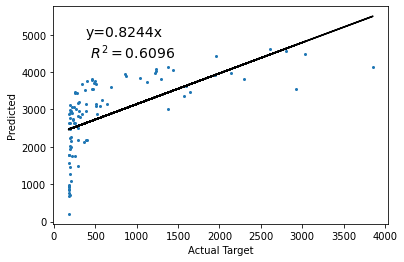

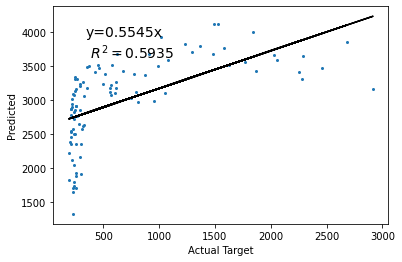

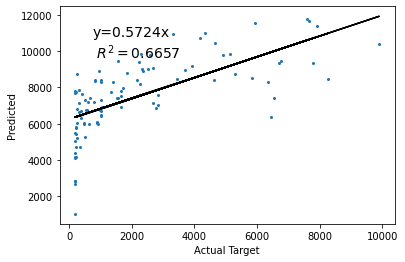

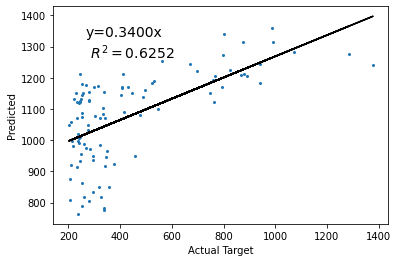

In [19]:

feed_dict = {x: x_train_ori,
             y: y_train0}
feed_dict[mu] = init_mu
# feed_dict[beta] = init_beta
# feed_dict[alpha] = init_alpha


# construct so-called feed dictionary to map placeholders to actual values

validation_feed_dict = {x: x_test_ori,
                        y: y_test0}

train_break = False
saver = tf.compat.v1.train.Saver({'W1':W1,'b1':b1,'W2':W2,'b2':b2,'W3':W3,'b3':b3})
current_loss = sess.run(cost,{x: x_train_ori,y: y_train0})

# Start training
start = time.time()
if not os.path.exists(os.path.join('/content/drive',
                                   'My Drive',
                                   google_drive_dir,
                                   "models",
                                   ann_name)):
    os.makedirs(os.path.join('/content/drive',
                                   'My Drive',
                                   google_drive_dir,
                                   "models",
                                   ann_name))

# current_br_loss = sess.run(br_loss,feed_dict)
with sess.as_default():
    with sess.graph.as_default():
        epoch = 1
        fail_step = 0
        # Training cycle
        while epoch < epochs and current_loss > target_mse:
            val_loss = sess.run(cost, validation_feed_dict)
            print('epoch: %3d , mu: %.5e, current loss: %.10f, val loss: %.10f'%(epoch,feed_dict[mu],current_loss,val_loss))
            sess.run(save_parms)
            while True:
                start_step = time.time()
                sess.run(lm, feed_dict)
                # print('One update ended in %d seconds' % (time.time()-start_step))
                new_loss = sess.run(cost,feed_dict)
                if new_loss > current_loss:
                    fail_step += 1
                    feed_dict[mu] *= 10
                    if feed_dict[mu] > mu_max or fail_step > max_fail:
                        train_break = True
                        break
                    sess.run(restore_parms)
                else:
                    print("mu: %.5e, new cost: %.5f, best cost: %.5f"%(feed_dict[mu],new_loss,current_loss))
                    fail_step = 0
                    feed_dict[mu] /= 10
                    feed_dict[mu] = max(1e-20,feed_dict[mu])
                    current_loss = new_loss
                    break
            if train_break:
                print('Failed for %d step(s), current mu = %.5e, stop training' % (fail_step,feed_dict[mu]))
                break
            epoch += 1
    end = time.time()
    print("Optimization Finished in %d seconds!" %(end - start))
    save_path = saver.save(sess, os.path.join('/content/drive','My Drive',google_drive_dir,"models/%s/model.ckpt"%ann_name))
    print("Model saved in path: %s" % save_path)

    # Test model
    y_train_predicted = sess.run(pred,feed_dict)
    y_test_predicted = sess.run(pred,validation_feed_dict)
    for ii in range(output_shape):
        show_eval(y_train_predicted[:,ii],
                y_train0[:,ii],
                y_test_predicted[:,ii],
                y_test0[:,ii],
                y_slope[ii],y_bias[ii],ann_name)
    writeF90(os.path.join('/content/drive',
                                   'My Drive',
                                   google_drive_dir,
                                   "models",
                                   ann_name),
             ann_name,y_slope[train_loc],y_bias[train_loc],
             sess.run(W1).transpose(),sess.run(b1),
             sess.run(W2).transpose(),sess.run(b2),
             sess.run(W3).transpose(),sess.run(b3))


In [20]:
# Adam again
with sess.as_default():
    with sess.graph.as_default():
        print("Train Error after LM:", acc.eval({x: x_train_ori, y: y_train0}))

# Start training

start = time.time()
with sess.as_default():
    with sess.graph.as_default():
        cost_list = []
        lr_list = []
        # Run the initializer
#         sess.run(init)

        # Training cycle
        total_batch = train_shape//batch_size
        for epoch in range(adam_epochs):
            avg_cost = 0.
            ii = 0
            # Loop over all batches
            for batch_xs, batch_ys in get_batch(x_train_ori, y_train0,batch_size):
                ii = ii +1
                # Run optimization op (backprop), cost op (to get loss value)
                # and summary nodes
                _, c = sess.run([adam_opt2, cost],
                                 feed_dict={x: batch_xs, y: batch_ys})
                # Write logs at every iteration
                # Compute average loss
                avg_cost += c / total_batch
            lr = learning_rate.eval()
            cost_list.append(avg_cost)
            lr_list.append(lr)
            # Display logs per epoch step
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost),
                  "lr = ","{:.10f}".format(lr))

    print("Optimization Finished!")

    # Test model
    # Calculate accuracy
    print("Train Error:", acc.eval({x: x_train_ori, y: y_train0}))
    print("Test Error:", acc.eval({x: x_test_ori, y: y_test0}))
    y_train_ = sess.run(pred,feed_dict={x:x_train_ori})
    y_test_ = sess.run(pred,feed_dict={x:x_test_ori})
    print("Train MSE:", np.mean(np.square((y_train_-y_train0)/y_slope)))
    print("Test MSE:", np.mean(np.square((y_test_-y_test0)/y_slope)))
    print("Train MAPE:", np.mean(np.abs(y_train_-y_train0)/y_train0))
    print("Test MAPE:", np.mean(np.abs(y_test_-y_test0)/y_test0))


Train Error after LM: 0.123465024
Epoch: 0001 cost= 0.115211427 lr =  0.0099999998
Epoch: 0002 cost= 0.095649647 lr =  0.0099999998
Optimization Finished!
Train Error: 0.08489468
Test Error: 0.092518955
Train MSE: 6196141.5
Test MSE: 6743493.0
Train MAPE: 1.9090732
Test MAPE: 1.885772
